Dataset Information:
Number of samples: 150
Number of features: 4
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target classes: ['setosa' 'versicolor' 'virginica']

Training set size: 105
Testing set size: 45

Performing Grid Search for hyperparameter optimization...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Best cross-validation score: 0.9810
Best parameters: {'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}

Accuracy on test set: 0.9111

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



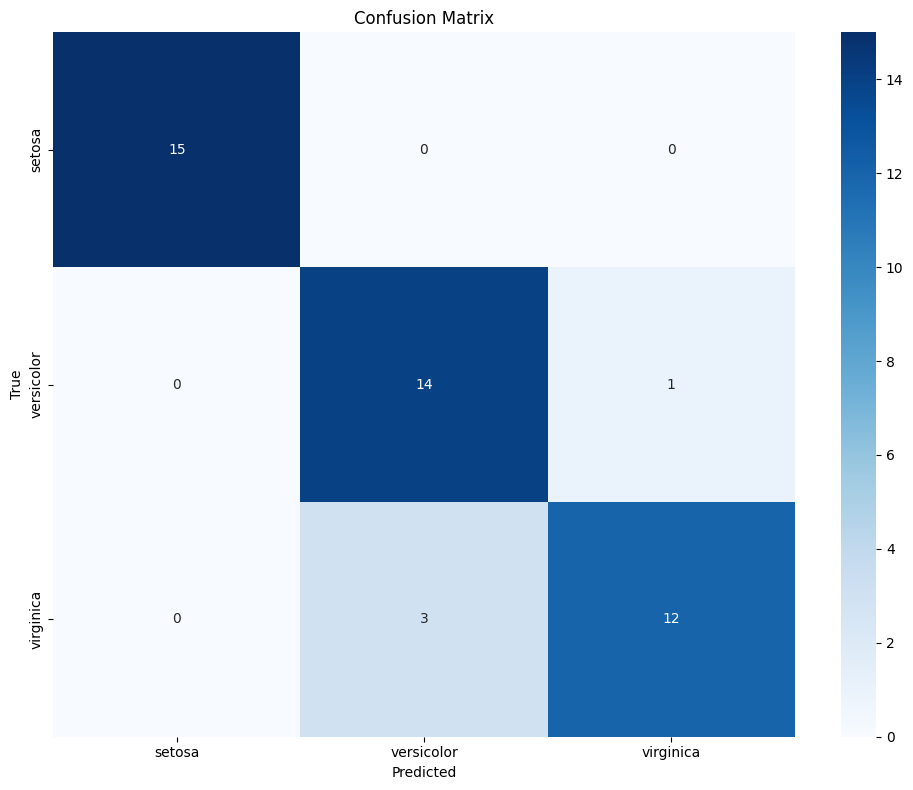

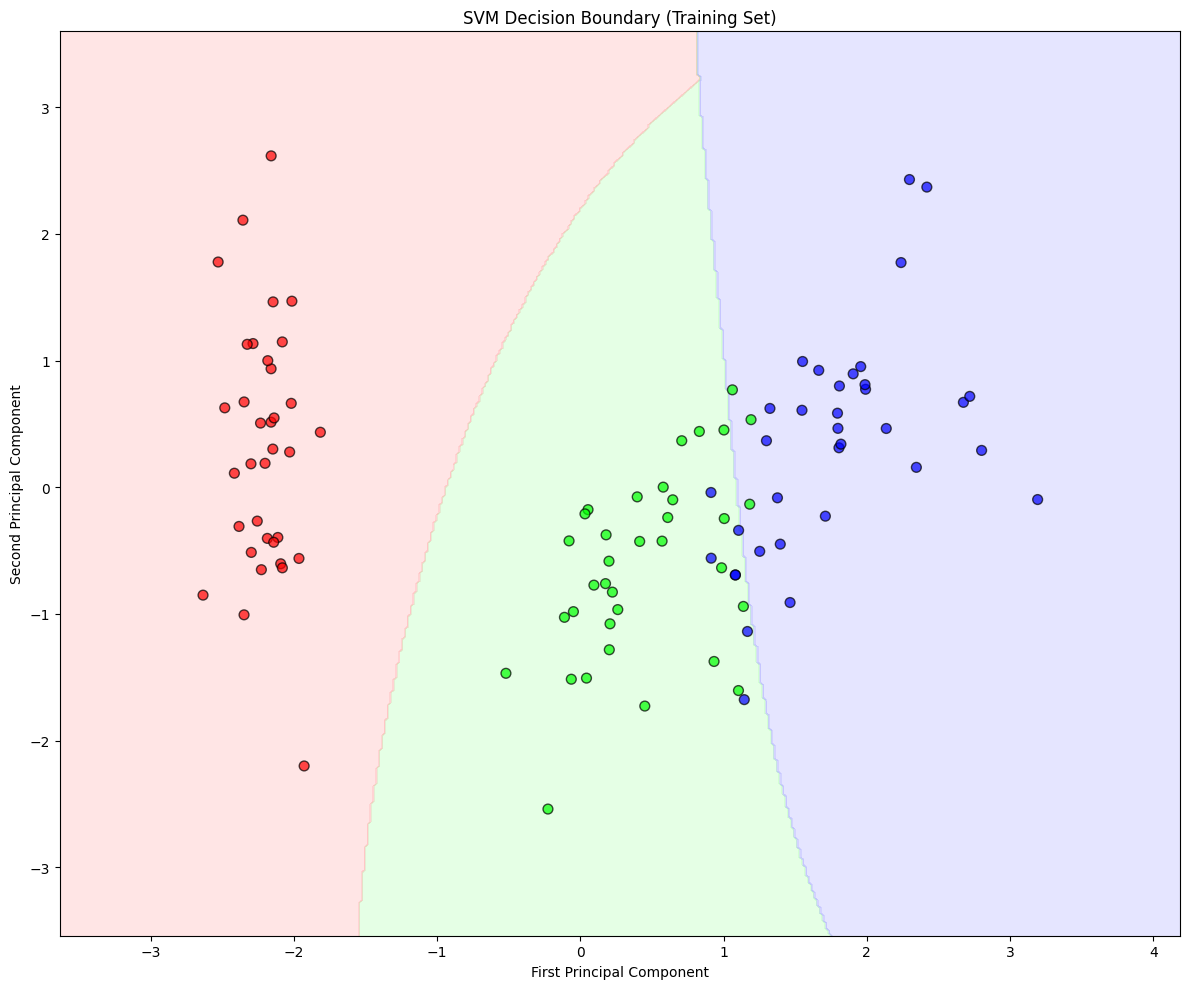

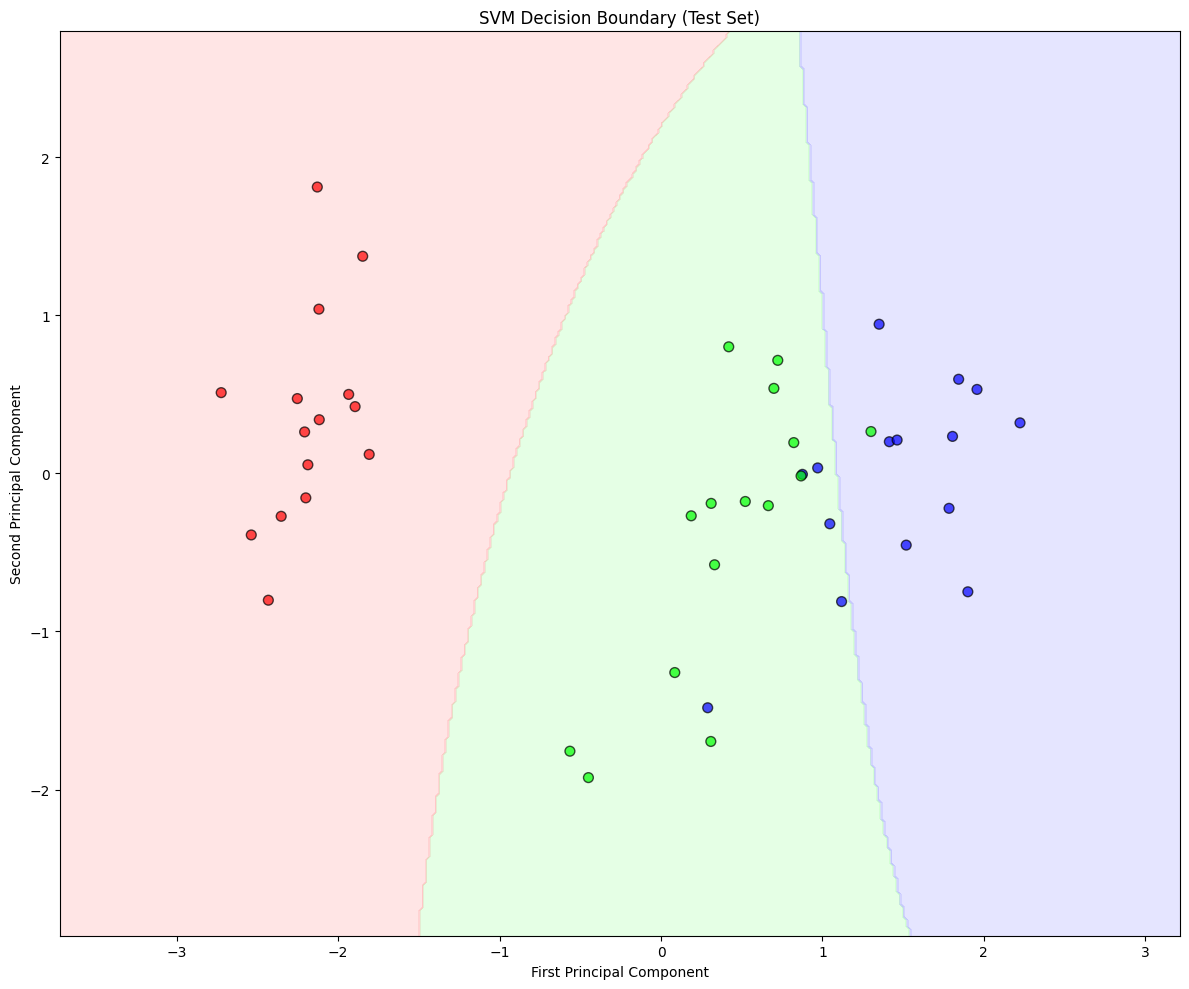

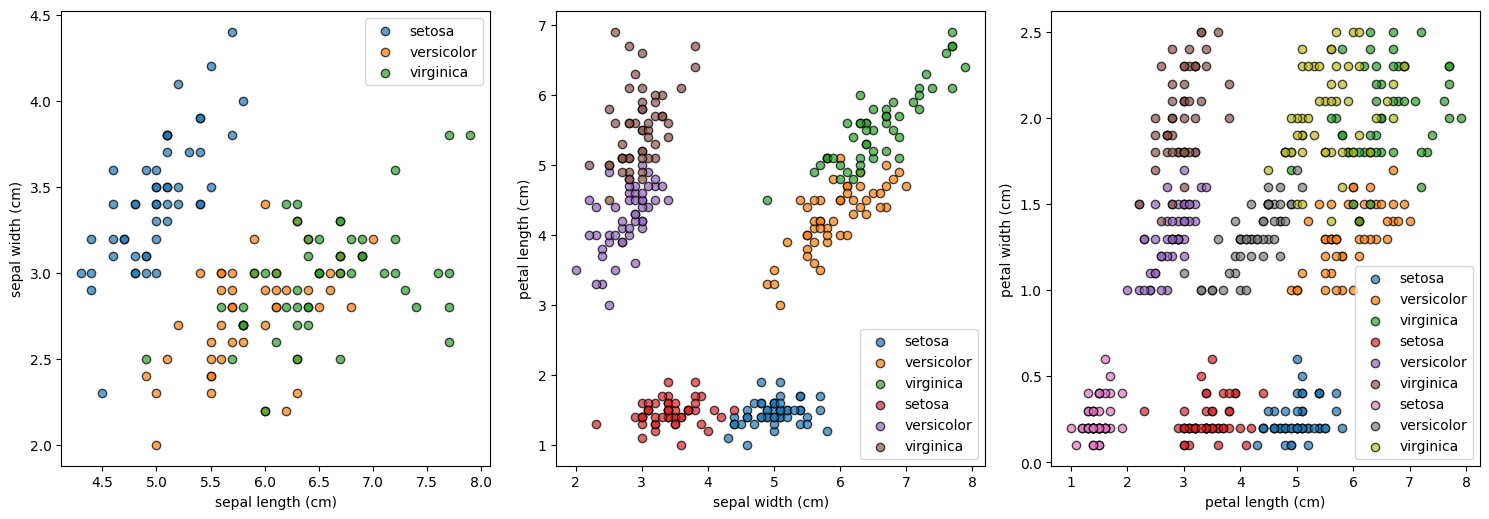

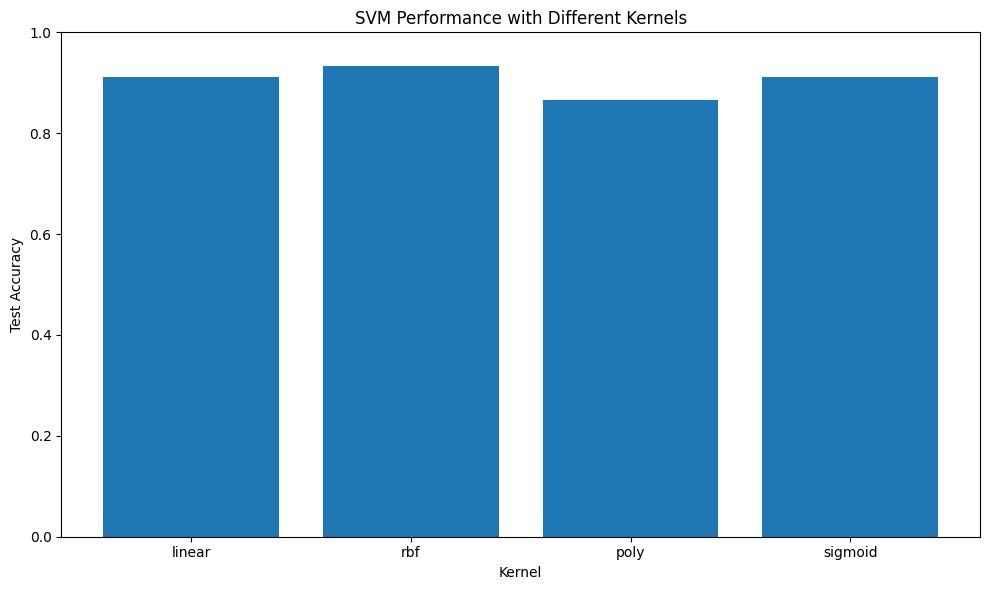


Final optimized SVM model:
SVC(C=1, degree=2, gamma=0.1, probability=True)

Training complete!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# Set random seed for reproducibility
np.random.seed(42)

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

print("Dataset Information:")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Feature names: {feature_names}")
print(f"Target classes: {target_names}")

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning using Grid Search
print("\nPerforming Grid Search for hyperparameter optimization...")
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4]  # Only relevant for poly kernel
}

grid_search = GridSearchCV(
    estimator=SVC(probability=True),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"\nBest cross-validation score: {best_score:.4f}")
print(f"Best parameters: {best_params}")

# Train the final model with the best parameters
best_svm = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_svm.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy on test set: {accuracy:.4f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('svm_confusion_matrix.png')
plt.show()

# Apply PCA for visualization (reducing to 2 dimensions)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Plot the decision boundary
def plot_decision_boundary(X, y, model, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(12, 10))
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolors='k', s=50, alpha=0.7)

    plt.title(title)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.tight_layout()

# Train a new SVM model on the PCA data with the best parameters
best_params_copy = best_params.copy()
svm_pca = SVC(**best_params_copy)
svm_pca.fit(X_train_pca, y_train)

# Plot the decision boundaries
plot_decision_boundary(X_train_pca, y_train, svm_pca, 'SVM Decision Boundary (Training Set)')
plt.savefig('svm_decision_boundary_train.png')
plt.show()

plot_decision_boundary(X_test_pca, y_test, svm_pca, 'SVM Decision Boundary (Test Set)')
plt.savefig('svm_decision_boundary_test.png')
plt.show()

# Visualize original data with feature pairs
plt.figure(figsize=(15, 10))
for i in range(4):
    for j in range(i+1, 4):
        plt.subplot(2, 3, i*(4-i)//2 + j-i)
        for k in range(3):
            plt.scatter(X[y == k, i], X[y == k, j],
                        label=target_names[k], alpha=0.7, edgecolors='k')
        plt.xlabel(feature_names[i])
        plt.ylabel(feature_names[j])
        plt.legend()
plt.tight_layout()
plt.savefig('iris_feature_pairs.png')
plt.show()

# Feature importance analysis (for linear kernel only)
if best_params['kernel'] == 'linear':
    linear_svm = SVC(kernel='linear', C=best_params['C'])
    linear_svm.fit(X_train_scaled, y_train)

    # Get feature importance from the weights of the linear SVM
    weights = linear_svm.coef_
    importance = np.sum(np.abs(weights), axis=0)
    importance = importance / np.sum(importance)

    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, importance)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance (Linear SVM)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

# Visualization of model performance with different kernels
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
test_scores = []

for kernel in kernels:
    svm = SVC(kernel=kernel)
    svm.fit(X_train_scaled, y_train)
    test_scores.append(svm.score(X_test_scaled, y_test))

plt.figure(figsize=(10, 6))
plt.bar(kernels, test_scores)
plt.xlabel('Kernel')
plt.ylabel('Test Accuracy')
plt.title('SVM Performance with Different Kernels')
plt.ylim([0, 1])
plt.tight_layout()
plt.savefig('kernel_comparison.png')
plt.show()

print("\nFinal optimized SVM model:")
print(best_svm)
print("\nTraining complete!")